In [3]:
import nilearn
from nilearn.image import resample_img
import nibabel as nib
from templateflow import api
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt

from nilearn.glm.first_level import FirstLevelModel
from nilearn import plotting

from scipy.signal import savgol_filter

In [4]:
subject_str = "MATHAI"
session_str = "SHAM"

In [5]:
path_to_func = f"/Users/jacekdmochowski/PROJECTS/fus/data/fmriprep_out/sub-{subject_str}/ses-{session_str}/func"
path_to_anat = f"/Users/jacekdmochowski/PROJECTS/fus/data/fmriprep_out/sub-{subject_str}/ses-{session_str}/anat"

In [6]:
matching_anats = glob.glob(os.path.join(path_to_anat,'*space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz'))
matching_funcs = glob.glob(os.path.join(path_to_func,'*space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'))
matching_masks = glob.glob(os.path.join(path_to_func,'*space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz'))

if len(matching_anats) == 1:
    anat_filename = matching_anats[0]
else:
    raise ValueError("No valid anatomical")

if len(matching_funcs) == 1:
    bold_filename = matching_funcs[0]
else:
    raise ValueError("No valid functional")

if len(matching_masks) == 1:
    mask_filename = matching_masks[0]
else:
    raise ValueError("No valid mask")

anat = nib.load(os.path.join(path_to_anat, anat_filename))
bold = nib.load(os.path.join(path_to_func, bold_filename))
mask = nib.load(os.path.join(path_to_func, mask_filename))

In [11]:
# load or generate resampled_bold and resampled_mask to disk
path_to_save_resampled_bold = os.path.join(path_to_func, f"sub-{subject_str}_ses-{session_str}_task-prefuspost_space-Schaefer2018_desc-preproc_bold_resampled.nii.gz")
path_to_save_resampled_mask = os.path.join(path_to_func, f"sub-{subject_str}_ses-{session_str}_task-prefuspost_space-Schaefer2018_desc-brain_mask_resampled.nii.gz")

## get atlas
path = api.get('MNI152NLin2009cAsym', atlas="Schaefer2018", desc="1000Parcels17Networks", resolution=2, suffix="dseg", extension="nii.gz")
atlas = nib.load(path)
target_affine = atlas.affine
target_shape = np.array(atlas.dataobj).shape

# get the atlas labels
atlas_labels = np.unique(np.array(atlas.dataobj))

if os.path.exists(path_to_save_resampled_bold):
    resampled_bold = nib.load(path_to_save_resampled_bold)
else:
    resampled_bold = resample_img(bold, target_affine=target_affine, target_shape=target_shape[0:3])
    nib.save(resampled_bold, path_to_save_resampled_bold)

if os.path.exists(path_to_save_resampled_mask):
    resampled_mask = nib.load(path_to_save_resampled_mask)
else:
    resampled_mask = resample_img(mask, target_affine=target_affine, target_shape=target_shape[0:3], interpolation='nearest')
    nib.save(resampled_mask, path_to_save_resampled_mask)

In [12]:
resampled_bold.shape, resampled_mask.shape, atlas.shape

((97, 115, 97, 900), (97, 115, 97), (97, 115, 97))

## Attempt at ICA

In [15]:
##

In [16]:
stim_onsets = np.array([0,60,120,180,240])+300
stim_len = 20
isi = 60

dm = pd.DataFrame(np.zeros(shape=(900,3)), columns=['baseline','fus','recovery'], index=np.arange(900))
dm["baseline"].iloc[0:300] = 1
dm["fus"].iloc[300:600] = 1
dm["recovery"].iloc[600:900] = 1

## percent signal change

In [17]:
mu_bsl = np.mean(resampled_bold.get_fdata()[:,:,:,0:300], axis=-1) # mean across time before stimulation at each voxel
mu_fus = np.mean(resampled_bold.get_fdata()[:,:,:,300:600], axis=-1)
mu_rec = np.mean(resampled_bold.get_fdata()[:,:,:,600:900], axis=-1)

sigma_bsl = np.std(resampled_bold.get_fdata()[:,:,:,0:300], axis=-1)
sigma_fus = np.std(resampled_bold.get_fdata()[:,:,:,300:600], axis=-1)
sigma_rec = np.std(resampled_bold.get_fdata()[:,:,:,600:900], axis=-1)

In [18]:
#mu_bsl.shape, mu_fus.shape, mu_rec.shape, sigma_bsl.shape, sigma_fus.shape, sigma_rec.shape
#plt.imshow(mu_bsl[:,:,40])

((97, 115, 97),
 (97, 115, 97),
 (97, 115, 97),
 (97, 115, 97),
 (97, 115, 97),
 (97, 115, 97))

In [19]:
is_outside_brain = resampled_mask.get_fdata() == 0

mu_bsl[is_outside_brain] = np.nan
mu_fus[is_outside_brain] = np.nan
mu_rec[is_outside_brain] = np.nan

sigma_bsl[is_outside_brain] = np.nan
sigma_fus[is_outside_brain] = np.nan
sigma_rec[is_outside_brain] = np.nan

In [20]:
mu_pct_change = (mu_fus-mu_bsl)/mu_bsl
mu_pct_change_img = nib.Nifti1Image(mu_pct_change, affine=target_affine)

mu_pct_change_rec = (mu_rec-mu_bsl)/mu_bsl
mu_pct_change_rec_img = nib.Nifti1Image(mu_pct_change_rec, affine=target_affine)

sigma_pct_change = (sigma_fus-sigma_bsl)/sigma_bsl
sigma_pct_change_img = nib.Nifti1Image(sigma_pct_change, affine=target_affine)

sigma_pct_change_rec = (sigma_rec-sigma_bsl)/sigma_bsl
sigma_pct_change_rec_img = nib.Nifti1Image(sigma_pct_change_rec, affine=target_affine)

/var/folders/rr/jrb2ds1j2pj23dsv9x3lk9y00000gn/T/ipykernel_14897/3310298630.py:7: RuntimeWarning: invalid value encountered in divide
  sigma_pct_change = (sigma_fus-sigma_bsl)/sigma_bsl
/var/folders/rr/jrb2ds1j2pj23dsv9x3lk9y00000gn/T/ipykernel_14897/3310298630.py:10: RuntimeWarning: divide by zero encountered in divide
  sigma_pct_change_rec = (sigma_rec-sigma_bsl)/sigma_bsl


In [ ]:
nrows=3
ncols=3
fig1, ax1 = plt.subplots(nrows, ncols, figsize=(10, 10))
cut_coords = range(-20,-2,2)

tmp = sigma_pct_change_img
# set all values in tmp where z < -10 to 0
#tmp.get_fdata()[:,:,0:48] = 0

for i, coord in enumerate(cut_coords):

    # convert index i from an integer between 0 and 19 to a row and column index
    ii = np.unravel_index(i, (nrows, ncols))
    row = ii[0]
    col = ii[1]
    plotting.plot_stat_map(tmp, bg_img = anat,
                           threshold=0.3, display_mode = 'z', cut_coords=[coord], axes=ax1[row,col], vmax = 1)

fig1.patch.set_facecolor('black')
#plt.savefig(f"sub-{subject_idx:02d}_sigma_pct_change.png", dpi=300, facecolor='grey')

In [ ]:
tmp = sigma_pct_change_rec_img
np.nanmax(tmp.get_fdata())

In [ ]:
nrows=3
ncols=3
fig1, ax1 = plt.subplots(nrows, ncols, figsize=(10, 10))
cut_coords = range(-8,9,2)
for i, coord in enumerate(cut_coords):

    # convert index i from an integer between 0 and 19 to a row and column index
    ii = np.unravel_index(i, (nrows, ncols))
    row = ii[0]
    col = ii[1]
    plotting.plot_stat_map(mu_pct_change_img, bg_img = anat,
                           threshold=0.3, display_mode = 'x', cut_coords=[coord], axes=ax1[row,col], vmax = 1)

fig1.patch.set_facecolor('black')
#plt.savefig(f"sub-{subject_idx:02d}_sigma_pct_change_rec.png", dpi=300, facecolor='grey')

In [ ]:
nrows=3
ncols=3
fig1, ax1 = plt.subplots(nrows, ncols, figsize=(10, 10))
cut_coords = range(-8,9,2)
for i, coord in enumerate(cut_coords):

    # convert index i from an integer between 0 and 19 to a row and column index
    ii = np.unravel_index(i, (nrows, ncols))
    row = ii[0]
    col = ii[1]
    plotting.plot_stat_map(sigma_pct_change_rec_img, bg_img = anat,
                           threshold=0.5, display_mode = 'x', cut_coords=[coord], axes=ax1[row,col], vmax = 1)

fig1.patch.set_facecolor('black')
#plt.savefig(f"sub-{subject_idx:02d}_mu_pct_change_rec.png", dpi=300, facecolor='grey')

In [ ]:
nrows=3
ncols=3
fig1, ax1 = plt.subplots(nrows, ncols, figsize=(10, 10))
cut_coords = range(-8,9,2)
for i, coord in enumerate(cut_coords):

    # convert index i from an integer between 0 and 19 to a row and column index
    ii = np.unravel_index(i, (nrows, ncols))
    row = ii[0]
    col = ii[1]
    plotting.plot_stat_map(mu_pct_change_img, bg_img = anat,
                           threshold=0.1, display_mode = 'x', cut_coords=[coord], axes=ax1[row,col], vmax = 1)

fig1.patch.set_facecolor('black')
#plt.savefig(f"sub-{subject_idx:02d}_mu_pct_change.png", dpi=300, facecolor='grey')

## ROI time series

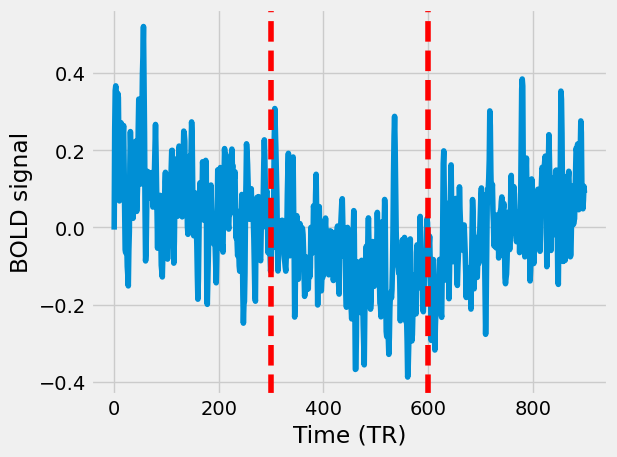

In [14]:
# get the time series of ROI 856
#roi_idx = [332,333]
#roi_idx = np.arange(938,948)
roi_idx = [855,856]

# create an roi mask that contains all indices in roi_idx
roi_mask = np.isin(atlas.get_fdata(), roi_idx)
roi_mask = roi_mask.astype(float)

roi_mask_img = nib.Nifti1Image(roi_mask, affine=target_affine)
roi_ts = nilearn.masking.apply_mask(resampled_bold, roi_mask_img)

## standardize each voxel in roi_ts
roi_ts = (roi_ts - np.mean(roi_ts, axis=0))/np.std(roi_ts, axis=0)

roi_ts_smooth = savgol_filter(roi_ts, window_length=10, polyorder=4, axis=0)

# switch to plot style of the fivethirtyeight
plt.style.use('fivethirtyeight')

plt.plot(np.mean(roi_ts_smooth,axis=1))
plt.axvline(x=300, color='r', linestyle='--')
plt.axvline(x=600, color='r', linestyle='--')
plt.xlabel('Time (TR)')
plt.ylabel('BOLD signal')

plt.tight_layout()
#plt.savefig(f"sub-{subject_idx:02d}_roi_ts_RH_ACC.png")

## GLM

Onset 0: 300 samples
Onset 1: 360 samples
Onset 2: 420 samples
Onset 3: 480 samples
Onset 4: 540 samples


<AxesSubplot: >

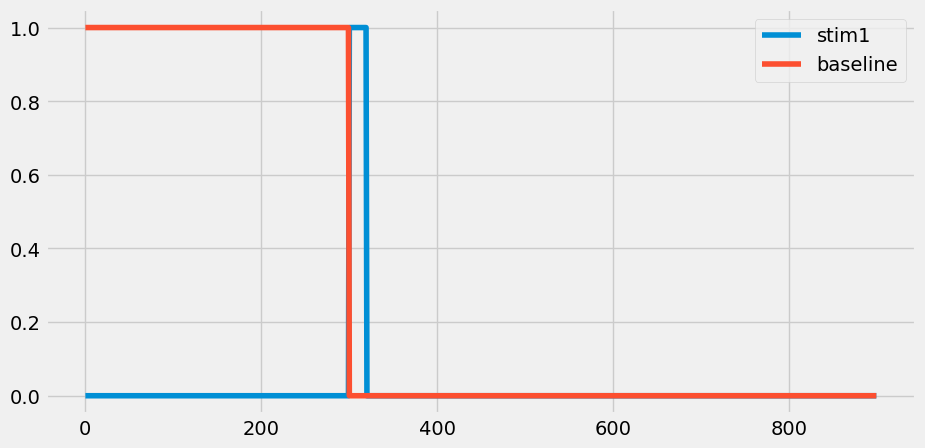

In [21]:
## design matrix generation
# column 1: baseline 0-300
stim_onsets = np.array([0,60,120,180,240])+300
stim_len = 20
isi = 60
dm = np.zeros((resampled_bold.shape[3],len(stim_onsets)+2))
# 1st column: baseline, 2nd column: stim onsets, 3rd column: stim offsets, 4th column: constant
# column 1: baseline 0-300
for i, onset in enumerate(stim_onsets):
    print(f"Onset {i}: {onset} samples")
    dm[onset:onset+stim_len,i] = 1

dm[0:300,5] = 1
dm[:,6] = 1

# create a pandas dataframe from dm
dm = pd.DataFrame(dm, columns=['stim1', 'stim2', 'stim3', 'stim4', 'stim5','baseline','constant'])
dm.plot(y=['stim1','baseline'], figsize=(10,5))

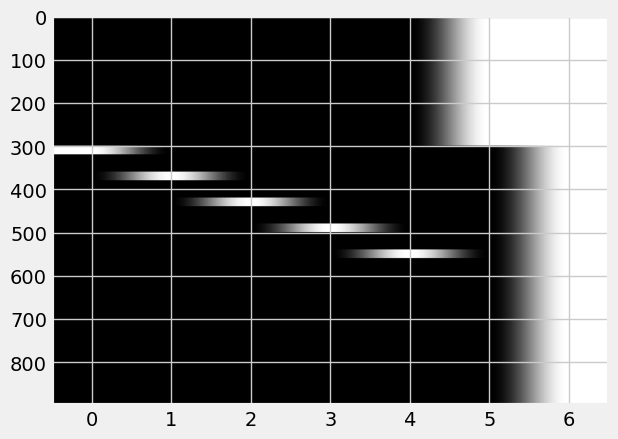

In [22]:
# draw the design matrix as an image
plt.imshow(dm, aspect='auto', cmap='gray', interpolation=None)

In [23]:
## set up a GLM analysis
first_level_model = FirstLevelModel(t_r=1.0,
                                    drift_model="cosine", high_pass=0.01,
                                    mask_img=resampled_mask,
                                    standardize=True)
first_level_model.fit(resampled_bold, design_matrices=[dm])

FirstLevelModel(mask_img=<nibabel.nifti1.Nifti1Image object at 0x31b68b1c0>,
                t_r=1.0)

In [29]:
#
# this is called a contrast (basically a weighted sum of the beta maps)
beta = first_level_model.compute_contrast('stim1+stim2+stim3+stim4+stim5-constant', output_type='z_score')

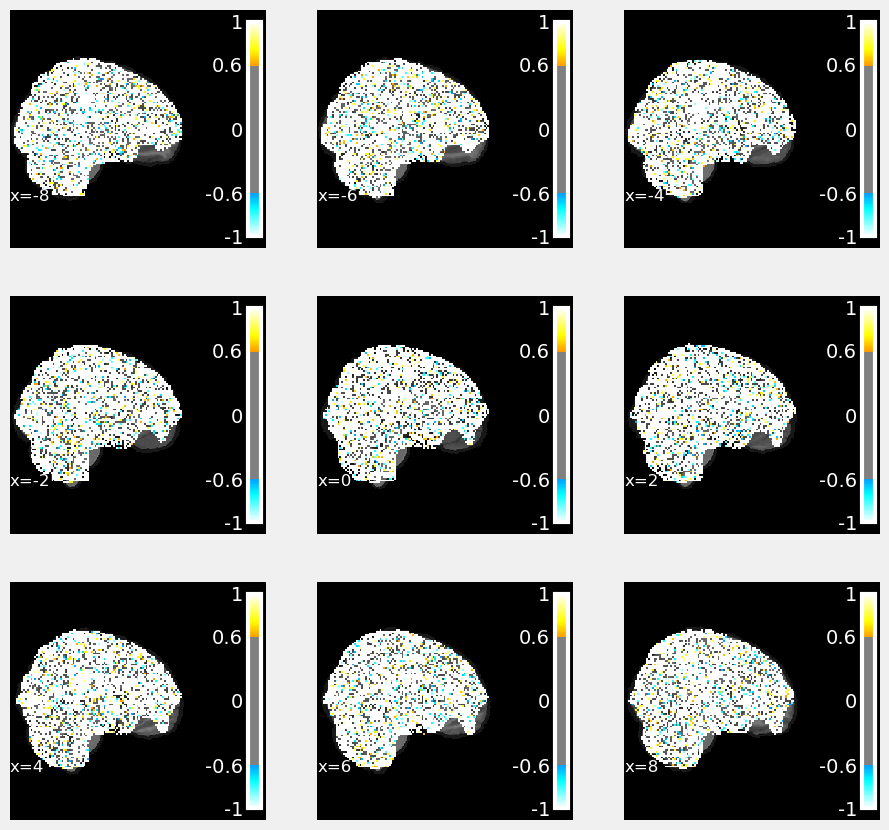

In [30]:
nrows=3
ncols=3
fig1, ax1 = plt.subplots(nrows, ncols, figsize=(10, 10))
cut_coords = range(-8,9,2)
for i, coord in enumerate(cut_coords):

    # convert index i from an integer between 0 and 19 to a row and column index
    ii = np.unravel_index(i, (nrows, ncols))
    row = ii[0]
    col = ii[1]
    plotting.plot_stat_map(beta, bg_img = anat,
                           threshold=0.6, display_mode = 'x', cut_coords=[coord], axes=ax1[row,col], vmax = 1)

#fig1.patch.set_facecolor('black')
#plt.savefig(f"sub-{subject_idx:02d}_mu_pct_change.png", dpi=300, facecolor='grey')

## ERP analyis

In [31]:
# epoch resampled_bold starting at each stim onset and with the epoch duration being 60 samples
epoch_duration = 60
#epochs = np.zeros((epoch_duration, len(stim_onsets), resampled_bold.shape[0], resampled_bold.shape[1], resampled_bold.shape[2]))
epochs = np.zeros((resampled_bold.shape[0], resampled_bold.shape[1], resampled_bold.shape[2], epoch_duration, len(stim_onsets) ))
for i, onset in enumerate(stim_onsets):
    epochs[:,:,:,:,i] = resampled_bold.get_fdata()[:,:,:,onset:onset+epoch_duration]

In [32]:
mu_epochs = np.mean(epochs, axis=-1)
mu_epochs_img = nib.Nifti1Image(mu_epochs, affine=target_affine)

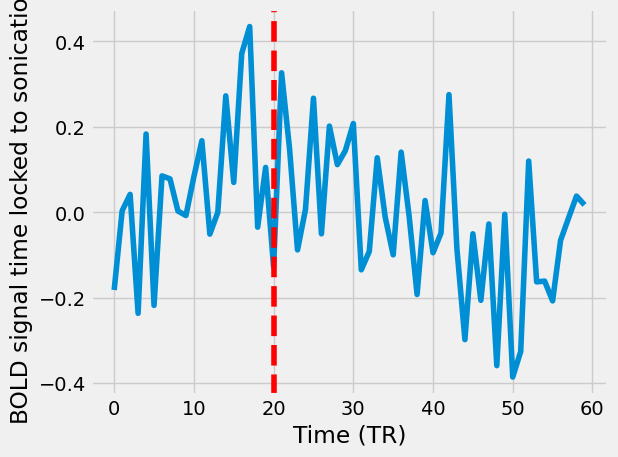

In [34]:
# extract the time series from the ROI 856
#roi_idx = [855,856]
roi_idx = [332,333]

roi_mask_img = nib.Nifti1Image(np.isin(atlas.get_fdata(), roi_idx).astype(float), affine=target_affine)
roi_ts = nilearn.masking.apply_mask(resampled_bold, roi_mask_img)

roi_epoched_ts = nilearn.masking.apply_mask(mu_epochs_img, roi_mask_img)

### standardize each voxel in roi_ts
roi_epoched_ts = (roi_epoched_ts - np.mean(roi_epoched_ts, axis=0))/np.std(roi_epoched_ts, axis=0)

roi_epoched_ts_smooth = savgol_filter(roi_epoched_ts, window_length=5, polyorder=4, axis=0)

plt.plot(np.mean(roi_epoched_ts_smooth, axis=1))
plt.axvline(x=20, color='r', linestyle='--', label='end FUS')
plt.xlabel('Time (TR)')
plt.ylabel('BOLD signal time locked to sonication')

plt.tight_layout()
#plt.savefig(f"sub-{subject_idx:02d}_roi_epoched_ts_LH_ACC.png")

In [ ]:
roi_epoched_ts_smooth.shape